In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from tifffile import imread
import copy
import json

In [2]:
from em2p_coreg import utils
from em2p_coreg.alignment import solve_3d as s3
from em2p_coreg.alignment.transform import StagedTransform, Transform

In [3]:
# transformation parameters
model = 'TPS'
npts = '5'
staged = 'True'

# Generate and load original transformation

In [4]:
# run transformation
args = s3.example2
args['model'] = model
args['npts'] = npts    
s2 = s3.Solve3D(input_data=s3.example2, args=[])
s2.run()

average residual [dst units]: 4222.3459


In [5]:
# compute residuals in destination units
residuals = np.round(np.linalg.norm(s2.residuals, axis=1).mean()/1000,decimals=2)

In [8]:
# load transformation
t = Transform(model=model)
with open(s2.args['output_json'], 'r') as f:
    t.from_dict(json.load(f))

# Generate and load staged transformation

In [3]:
# solve just with polynomial
args_poly = copy.deepcopy(s3.example2)
args_poly['model'] = 'POLY'
s_poly = s3.Solve3D(input_data=args_poly, args=[])
s_poly.run()
tf_poly = s_poly.transform
# write the transformed result to file
# for input to the next stage
tmp_path = '/src/em2p_coreg/python/em2p_coreg/outputs/poly_results.csv'
s3.write_src_dst_to_file(
        tmp_path,
        s_poly.data['dst'],
        tf_poly.transform(s_poly.data['src']))

# solve with thin plate spline on top
args_tps = copy.deepcopy(s3.example2)
args_tps['model'] = 'TPS'
args_tps['npts'] = 10
args_tps['data'] = {
        'landmark_file': tmp_path,
        'header': ['emx', 'emy', 'emz', 'polyx', 'polyy', 'polyz'],
        'sd_set': {'src': 'poly', 'dst': 'em'}
        }
args_tps['regularization']['other'] = 1e-5
s_tps = s3.Solve3D(input_data=args_tps, args=[])
s_tps.run()
tf_tps = s_tps.transform

# this object combines the 2 transforms
# it converts input em units into the final units
# through both transforms
tf_total = StagedTransform([tf_poly, tf_tps])

average residual [dst units]: 10852.1490
wrote /src/em2p_coreg/python/em2p_coreg/outputs/poly_results.csv
average residual [dst units]: 5931.9636


In [4]:
# let's convince ourselves it works
total_tfsrc = tf_total.transform(s_poly.data['src'])
total_res = s_poly.data['dst'] - total_tfsrc
assert np.all(np.isclose(total_res, s_tps.residuals))

AssertionError: 

In [5]:
# how far did the control points move for the thin plate part?
csrc = tf_tps.control_pts
cdst = tf_tps.transform(csrc)
delta = cdst - csrc
avdelta = np.linalg.norm(delta, axis=1).mean()
print('control points moved average of %0.1fum' % (avdelta * 1000))

control points moved average of 61452985.8um


In [6]:
# how does this compare with what we were trying earlier?
# I already see n=10 looks crazy, let's just try n=5 for starters
args_old = copy.deepcopy(s3.example1)
s_old = s3.Solve3D(input_data=args_old, args=['--npts', '5'])
s_old.run()
csrc_old = s_old.transform.control_pts
cdst_old = s_old.transform.transform(csrc_old)
cdst_new = tf_total.transform(csrc_old)
delta2 = cdst_old - cdst_new
avdelta2 = np.linalg.norm(delta2, axis=1).mean()
print('compared to old, dst points different on average of %0.1fum' % (avdelta2 * 1000))

average residual [dst units]: 0.0045
compared to old, dst points different on average of 854000104297357377536.0um


In [12]:
# load transformation
t = Transform(model=model)
with open(tf_total.args['output_json'], 'r') as f:
    t.from_dict(json.load(f))

AttributeError: 'StagedTransform' object has no attribute 'args'

# Load source 2P and EM stacks

In [4]:
# load 2P stacks
cell_stack = imread('./stacks/sharpened_stack.tif') 
vess_stack = imread('./stacks/sharpened_vessels.tif')
segm_stack = (imread('./stacks/segmentation_stack.tif')>0).astype(np.int)

# load EM stack
EM_stack = np.load('./stacks/EM_at_1_um_per_px.npy')
EM_center = np.array([538560.0, 901280.41, 945454.55])[::-1] # had to flip it because I need it in x, y, z

# Get 2P coordinates and field

In [5]:
# generate stack coordinates
x, y, z = np.meshgrid(np.arange(1412), np.arange(1322),np.arange(670), indexing='ij')
stack_grids = np.stack([x,y,z],-1)

In [6]:
# get 2P field
depth = 150
grid_2p = stack_grids[:,:,depth,:]
cell_field = cell_stack[depth]
vess_field = vess_stack[depth]
segm_field = segm_stack[depth]

# Transform 2P coordinates to EM coordinates and get EM field

In [7]:
# transform 2P field and get EM field
EM_grid = utils.uncoordinate(tf_total.transform(utils.coordinate(grid_2p)/1000),1412,1322)
centered_EM_grid = (EM_grid - EM_center) / 1000
EM_field = utils.sample_grid(EM_stack, centered_EM_grid).numpy()

# Prepare images for figures

In [8]:
EM_image = utils.normalize(EM_field.T,clip_bounds=[20,200],scale=255, astype=np.float)
# as RGB images
cell_image = np.stack([np.zeros_like(cell_field).astype(np.uint8), utils.normalize(cell_field, scale=255, astype=np.uint8), np.zeros_like(cell_field).astype(np.uint8)],-1)
vess_image= np.stack([utils.normalize(vess_field, scale=255, astype=np.uint8), np.zeros_like(vess_field).astype(np.uint8), np.zeros_like(vess_field).astype(np.uint8)],-1)
segm_image = np.stack([np.zeros_like(segm_field).astype(np.uint8), np.zeros_like(segm_field).astype(np.uint8), utils.normalize(segm_field, scale=255, astype=np.uint8)],-1)
combined_2P_image = np.stack([utils.normalize(vess_field, scale=255, astype=np.uint8), utils.normalize(cell_field, scale=255, astype=np.uint8), utils.normalize(segm_field, scale=255, astype=np.uint8)],-1)

In [9]:
# as RGBA with background transparency
cell_overlay = np.stack([np.zeros_like(cell_field), np.ones_like(cell_field), np.zeros_like(cell_field), utils.normalize(cell_field, astype=np.float)],-1)
vess_overlay= np.stack([np.ones_like(vess_field), np.zeros_like(vess_field), np.zeros_like(vess_field), utils.normalize(vess_field, astype=np.float)],-1)
segm_overlay = np.stack([np.zeros_like(segm_field), np.zeros_like(segm_field), np.ones_like(segm_field), utils.normalize(segm_field, astype=np.float)],-1)

# Figures

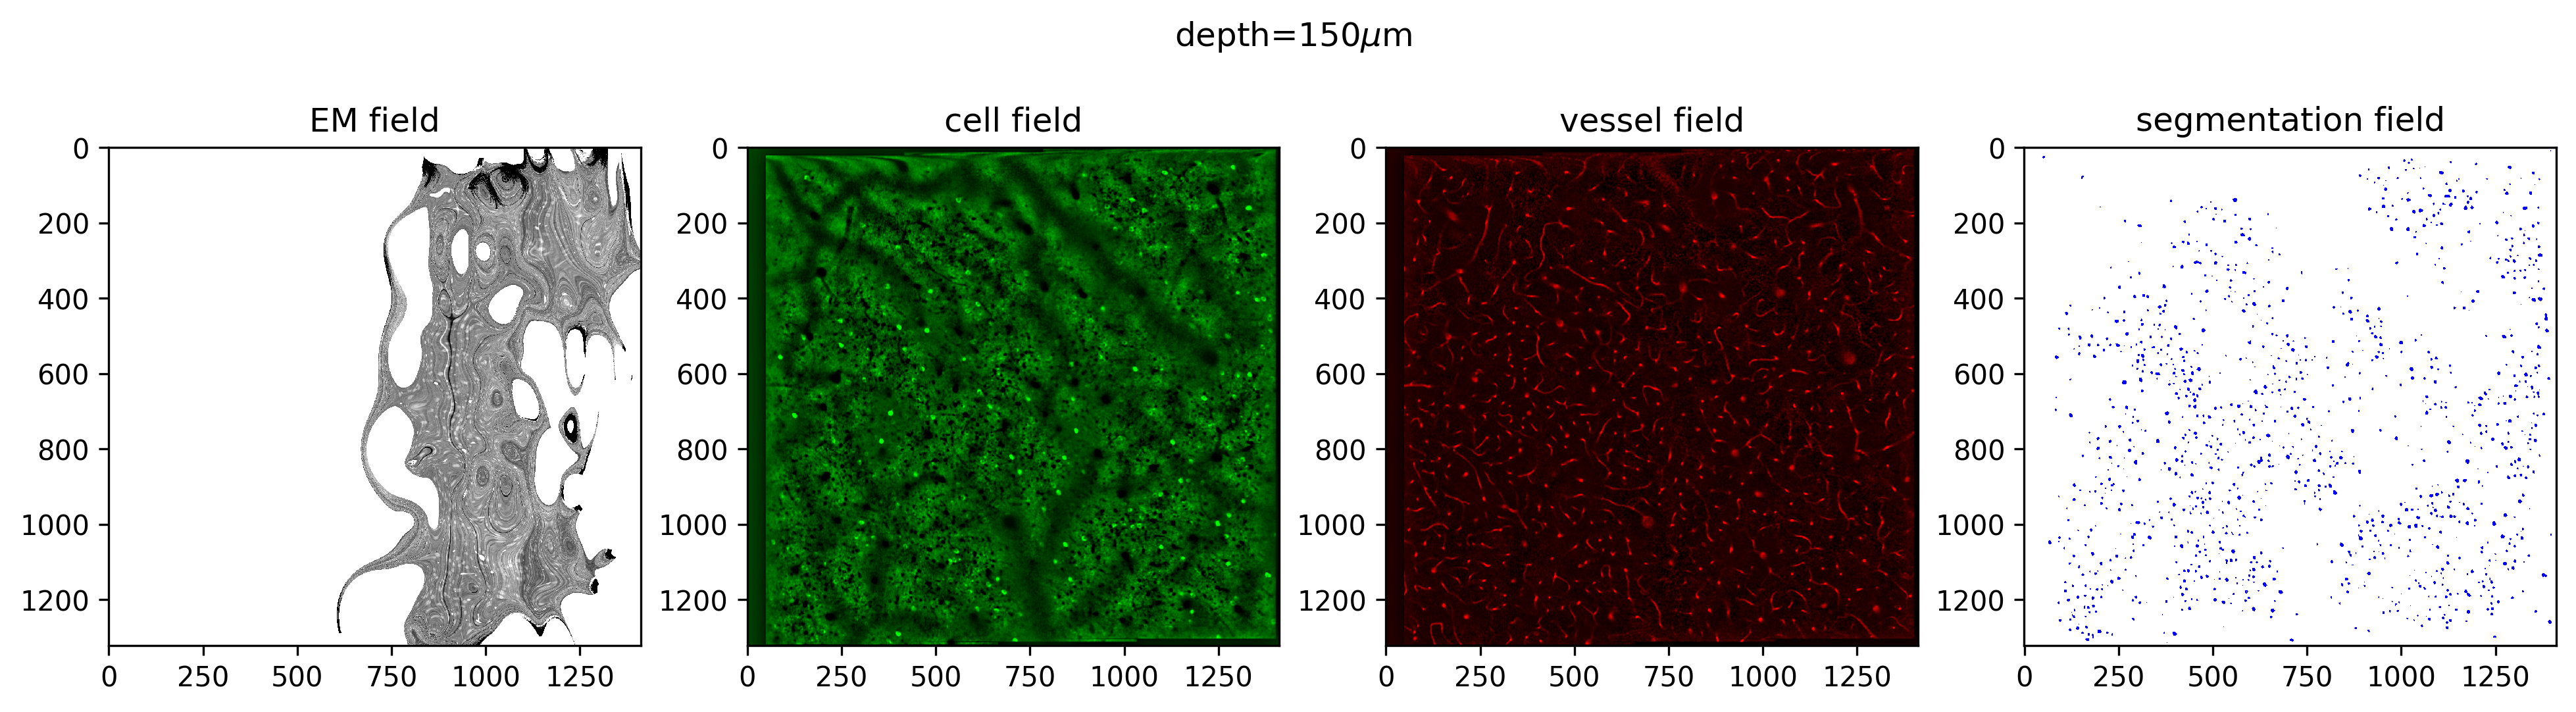

In [10]:
separate_2P=True
if separate_2P:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
    axes[0].imshow(-EM_image, cmap='gray')
    axes[1].imshow(cell_image)
    axes[2].imshow(vess_image)
    axes[3].imshow(segm_overlay)

    axes[0].set_title('EM field')
    axes[1].set_title('cell field')
    axes[2].set_title('vessel field')
    axes[3].set_title('segmentation field')
    fig.suptitle(f'depth={depth}$\mu$m')
else:
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    axes[0].imshow(-EM_image, cmap='gray')
    axes[1].imshow(combined_2P_image)
    fig.set_dpi(300)
    axes[0].set_title('EM field')
    axes[1].set_title('2P field')
    fig.suptitle(f'depth: {depth}$\mu$m')

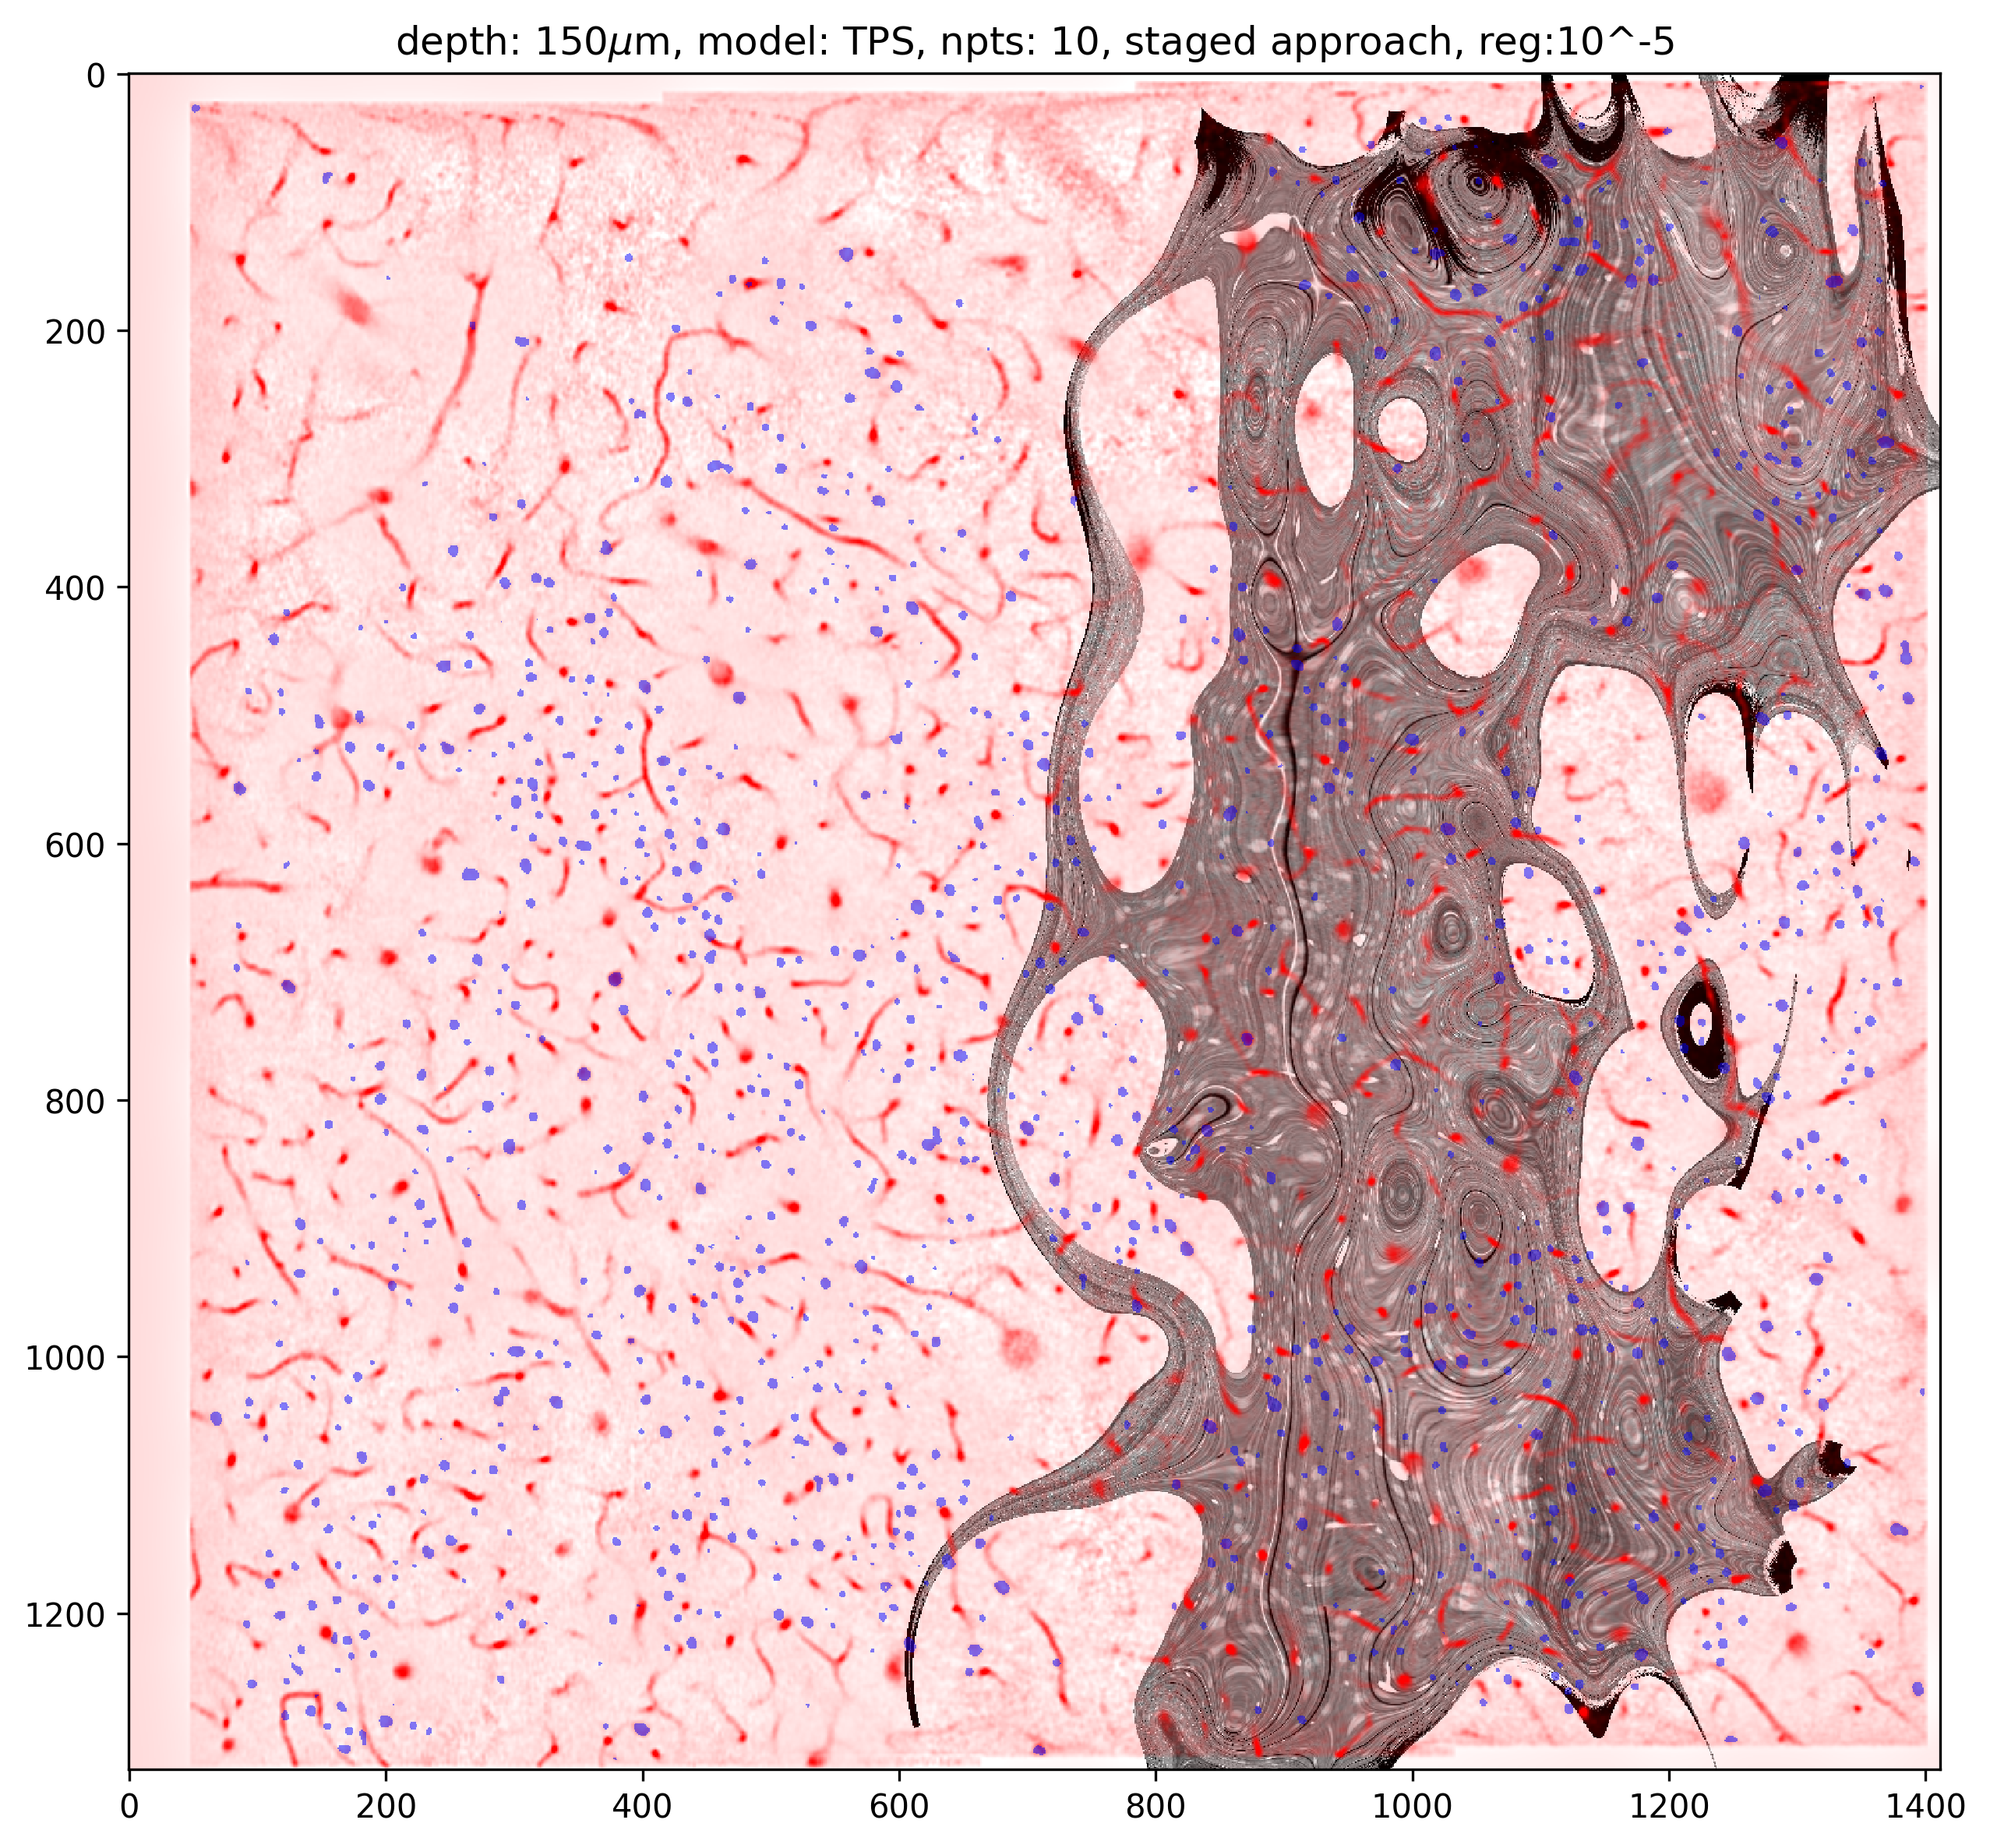

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(-EM_image, alpha=1, cmap='gray')
ax.imshow(vess_overlay)
ax.imshow(segm_overlay, alpha=0.5)
fig.set_dpi(300)
# ax.set_title(f'depth: {depth}$\mu$m, model: {model}, npts: {npts}, residuals: {residuals}$\mu$m')
# fig.savefig(f'./images/bug_fix_test/{depth}um_{model}_npts-{npts}.png')

ax.set_title(f'depth: {depth}$\mu$m, model: TPS, npts: 10, staged approach, reg:10^-5')
fig.savefig(f'./images/bug_fix_test/{depth}um_TPS_npts-5_staged_with-reg.png')